Loading required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline

Load Data from CSV File

In [2]:
df = pd.read_csv("movies.csv")
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df2 = pd.read_csv("ratings.csv")
df2.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Size of the data

In [4]:
print("No of ratings: ", len(df2))
users = len(df2['userId'].unique())
movies = len(df2['movieId'])
print("No of unique users: ", users)
print("No of unique movies rated: ", movies)

No of ratings:  100836
No of unique users:  610
No of unique movies rated:  100836


Mean Rating of all movies

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

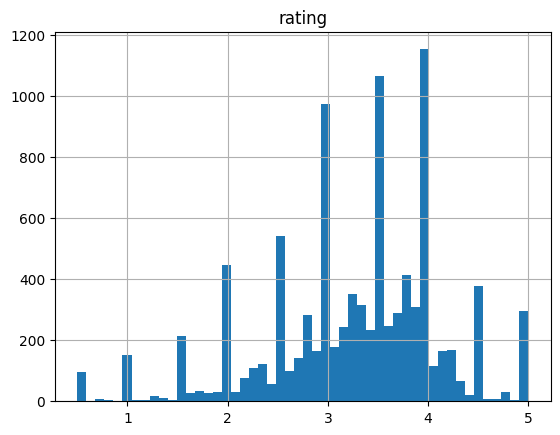

In [5]:
mean_rating = df2.groupby('movieId')[['rating']].mean()
mean_rating

mean_rating.hist(bins=50)

Movie with lowest and highest mean rating

In [6]:
lowest_rated = mean_rating['rating'].idxmin()
print("Lowest rated movie\n",df.loc[df['movieId'] == lowest_rated])
highest_rated = mean_rating['rating'].idxmax()
print("Highest rated movie\n",df.loc[df['movieId'] == highest_rated])

Lowest rated movie
       movieId         title   genres
2689     3604  Gypsy (1962)  Musical
Highest rated movie
     movieId            title           genres
48       53  Lamerica (1994)  Adventure|Drama


Function to convert the dataset into a matrix

In [7]:
from scipy.sparse import csr_matrix

def create_matrix(df): 
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
      
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
      
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
      
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]
  
    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
      
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [8]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(df2)

Similar Movies function

In [9]:
from sklearn.neighbors import NearestNeighbors
"""
Find similar movies using KNN
"""
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
      
    neighbour_ids = []
      
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

Converting data to surprise readable format

In [10]:
from surprise import Reader
from surprise import Dataset

In [11]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df2[["userId", "movieId", "rating"]], reader)
trainset = data.build_full_trainset()

Finding parameters for best accuracy for KNN model

In [12]:
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV


In [13]:
sim_options = {
    "name": ["msd", "cosine", "pearson"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

best_params = gs.best_params["rmse"]["sim_options"]

print(gs.best_score["rmse"])
print(best_params)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Recommendation function

In [14]:
def recommend(best_params,user_id, k=10):
      
    neighbour_ids = []
    
    knn = KNNWithMeans(sim_options=best_params)
    knn.fit(trainset)
    values = []
    movie_ids = list(np.unique(df["movieId"]))
    for id in movie_ids:
        prediction = knn.predict(user_id, id)
        values.append(prediction.est)

    for i in range(k):
        v = values.index(max(values))
        neighbour_ids.append(movie_ids.pop(v))
        values.pop(v)

    return neighbour_ids


User based Recommendation

In [15]:
userid = 106
movies = recommend(best_params, userid)

movie_titles = dict(zip(df['movieId'], df['title']))

print("Recommeded movies for user: ", userid)
for i in movies:
    print(movie_titles[i])

Computing the msd similarity matrix...
Done computing similarity matrix.
Recommeded movies for user:  106
City of Lost Children, The (Cité des enfants perdus, La) (1995)
Usual Suspects, The (1995)
Beautiful Girls (1996)
Bottle Rocket (1996)
Chungking Express (Chung Hing sam lam) (1994)
Prophecy, The (1995)
Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)
Circle of Friends (1995)
Heavenly Creatures (1994)
New Jersey Drive (1995)


Movie based recommendation

In [16]:
movie_id = 58347
  
similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]
  
print(f"Since you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Since you watched Penelope (2006)
Agent Cody Banks (2003)
FairyTale: A True Story (1997)
Alice (2009)
Last Legion, The (2007)
Hunt For Gollum, The (2009)
Dead Like Me: Life After Death (2009)
Earthsea (Legend of Earthsea) (2004)
Cirque du Freak: The Vampire's Assistant (2009)
Merlin (1998)
Animal Farm (1954)
